In [1]:
import logging

In [2]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV

In [4]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

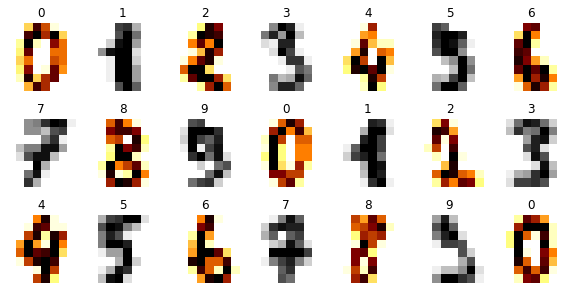

In [5]:
_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [7]:
def fit_plot_confusion(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train % 2)

    mean, std = clf.cv_results_['mean_test_score'][clf.best_index_], \
                clf.cv_results_['std_test_score'][clf.best_index_]

    logging.info(clf.best_params_)

    disp = metrics.plot_confusion_matrix(clf, X_test, y_test % 2, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return clf.best_estimator_, {"mean": mean, "std": std}

# Logistic regression

#### classes {-1, 1}

$$ \hat{y_{i}} = sign (<w, x_{i}>)  = sign(w^{(0)} + \sum_{j=1}^{n} w^{(j)}x^{(j)}_{i}) \in \{-1, 1\}$$

$$ P(y_{i} = 1 | x_{i}) = 1 - P(y_{i} = -1 | x_{i}) $$

$$P(y_{i} = 1 | x_{i}) = \frac{1}{1 + e^{-{<w, x_{i}>}}} $$

$$P(y_{i} = -1 | x_{i}) = 1 - \frac{1}{1 + e^{-{<w, x_{i}>}}} = \frac{e^{-{<w, x_{i}>}}}{1 + e^{-{<w, x_{i}>}}}$$

$$ \frac{P(y_{i} = 1 | x_{i})}{P(y_{i} = -1 | x_{i})} = \frac{P(y_{i} = 1 | x_{i})}{1 - P(y_{i} = 1 | x_{i})} = e^{<w, x_{i}>}$$

$$ M_{i} = y_{i} <w,x_{i}> $$


$$ Q(w, X, y) = \sum_{i=1}^{N} [M_{i} < 0] \leq \sum_{i=1}^{N} \log_2 (1 + e^{-M_{i}})$$
$$ Loss(w, X, y) = \sum_{i=1}^{N} \ln (1 + e^{-M_{i}}) \to min $$

#### classes {0, 1}

$$ p(x_{i}) = P(y_{i} = 1 | x_{i}) = 1 - P(y_{i} = 0 | x_{i}) $$
$$ p(x_{i}) = \frac{1}{1 + e^{-{<w, x_{i}>}}} $$
$$ 1 - p(x_{i}) = \frac{e^{-{<w, x_{i}>}}}{1 + e^{-{<w, x_{i}>}}} = \frac{1}{1 + e^{<w, x_{i}>}}$$

$$ M_{i} = (2y_{i} - 1)<w,x_{i}> $$

$$ \ln (1 + e^{-M_{i}}) = [y_{i} == 1] = \ln (1 + e^{-{<w, x_{i}>}}) = -\ln p(x_{i}) = -y_{i}\ln p(x_{i})$$ 
$$ \ln (1 + e^{-M_{i}}) = [y_{i} == 0] = \ln (1 + e^{{<w, x_{i}>}}) = -\ln (1 - p(x_{i})) = -(1 - y_{i}) \ln (1 - p(x_{i}))$$

In [8]:
lr_param_grid = {'C': [0.01, 0.1, 1.0, 10.0],
                 'penalty': ['l1', 'l2']}
lr_clf = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000, solver='saga', n_jobs=-1), lr_param_grid)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

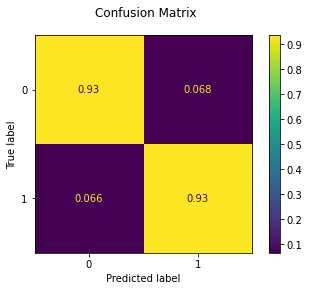

In [9]:
lr_best_clf, lr_stats = fit_plot_confusion(lr_clf, X_train, y_train, X_test, y_test)

In [10]:
lr_stats

{'mean': 0.913017808749516, 'std': 0.004836760107170642}

In [11]:
lr_best_clf.intercept_

array([-0.05335016])

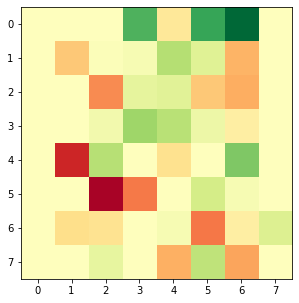

In [12]:
coef = lr_best_clf.coef_[0]
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
plt.imshow(coef.reshape(8, 8), interpolation='nearest',
           cmap=plt.cm.RdYlGn, vmin=-scale, vmax=scale)

In [13]:
y_pred = lr_best_clf.predict(X_test)

In [14]:
metrics.accuracy_score(y_pred=y_pred, y_true=y_test % 2)

0.9333333333333333

# KNN

In [15]:
knn_param_grid = {'n_neighbors': [1, 2, 3, 5, 30, 100], 'weights': ['uniform', 'distance']}
knn_clf = GridSearchCV(KNeighborsClassifier(n_jobs=-1), knn_param_grid)

INFO:root:{'n_neighbors': 3, 'weights': 'uniform'}
/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


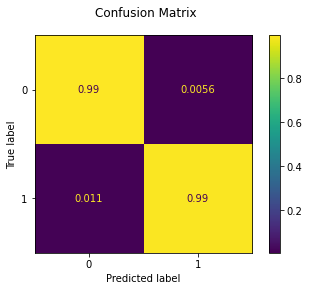

In [16]:
knn_best_clf, knn_stats = fit_plot_confusion(knn_clf, X_train, y_train, X_test, y_test)

In [17]:
knn_stats

{'mean': 0.9937354819976771, 'std': 0.005569484902294557}

In [18]:
y_pred = knn_best_clf.predict(X_test)

In [19]:
metrics.accuracy_score(y_pred=y_pred, y_true=y_test % 2)

0.9916666666666667